In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [27]:
train_data_file = "~/data2.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["Unnamed: 0", "eventID", "track_particle_key", "track_position_z", "track_ghostProbability", "track_chi2", "track_phi", "track_position_phi"] , axis=1).astype(np.float64)
isDown = data.particle_isDown.values.astype(np.float64)
noVelo = data.particle_isDown_noVelo.values.astype(np.float64)
features = features.drop(["particle_isDown_noVelo", "particle_isDown", features.columns[0]], axis=1).values
d=isDown.sum()
v=noVelo.sum()
zipped=(zip(isDown, noVelo))
targets = np.array([(down==1 and velo==1) for down, velo in zipped]).astype(np.float64)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2)

**RandomForestClassifier**

In [35]:
RFC = RandomForestClassifier(1500, max_depth = 12)

In [36]:
RFC.fit(X_train, y_train)
pred_RFC = RFC.predict(X_test)

In [37]:
print(classification_report(y_test, pred_RFC))
print(confusion_matrix(y_test, pred_RFC))


              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92     26982
         1.0       0.00      0.00      0.00      4515

    accuracy                           0.86     31497
   macro avg       0.43      0.50      0.46     31497
weighted avg       0.73      0.86      0.79     31497

[[26980     2]
 [ 4515     0]]


In [38]:
proba = RFC.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])

In [33]:
def plot_roc(fpr, tpr):
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

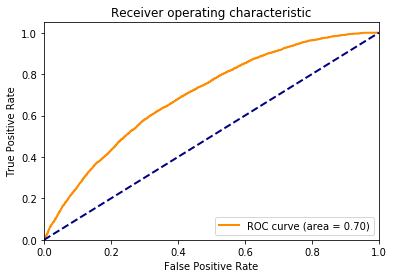

In [39]:
plot_roc(fpr, tpr)

In [10]:
param_grid = {
    'max_depth': [16, 20],
    'n_estimators': [60, 100, 200, 500, 1000]
}
RFCGS = RandomForestClassifier()

In [11]:
grid_search = GridSearchCV(estimator = RFCGS, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [12]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

In [14]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [15]:
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 500}

In [16]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.65      0.74     13687
         1.0       0.77      0.91      0.84     17810

    accuracy                           0.80     31497
   macro avg       0.81      0.78      0.79     31497
weighted avg       0.81      0.80      0.79     31497



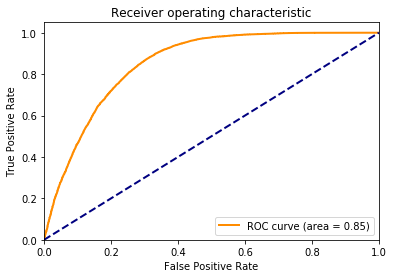

In [17]:
proba = best_grid.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
plot_roc(fpr, tpr)

In [18]:
RFCRS = RandomForestClassifier()
random_grid = {
    'criterion': ["entropy", "gini"],
    'max_depth': [12, 16, 20],
    'n_estimators': [100, 200, 500, 800, 1200, 1400, 1600]
}

In [19]:
random_search = RandomizedSearchCV(estimator = RFCRS, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/home/halaka/pytorch-env/lib64/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 42 is smaller than n_iter=100. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 111 out of 126 | elapsed: 28.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 32.3min finished


In [24]:
random_search.best_params_

{'n_estimators': 1600, 'max_depth': 20, 'criterion': 'entropy'}

In [25]:
best_grid_random = random_search.best_estimator_
evaluate(best_grid_random, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.65      0.74     13687
         1.0       0.77      0.92      0.84     17810

    accuracy                           0.80     31497
   macro avg       0.81      0.78      0.79     31497
weighted avg       0.81      0.80      0.79     31497



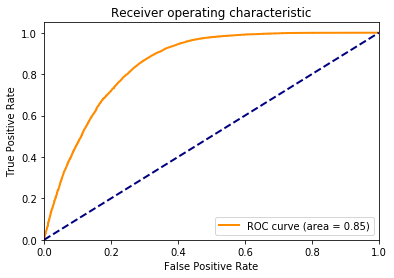

In [26]:
proba = best_grid_random.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
plot_roc(fpr, tpr)